# Logical shadow tomography: $[[5, 1, 3]]$ code example

## Setup

In [1]:
import functools
from joblib import Parallel, delayed
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from numba import njit

import qutip

from base.stabilizer import random_clifford_state, stabilizer_state, stoc_depolarize_map
from base.utils import stabilizer_projection_full
from convert import state2state as stabilizer_state_to_qutip_qobj, state2projector

In [2]:
plt.rcParams.update({"font.family": "serif", "font.size": 16})

## Experiment

In [3]:
"""Set experimental parameters."""
num_trajectories: int = 200_000  # Number of trajectories to sample from.

pmin: float = 0.0  # Minimum depolarizing noise rate.
pmax: float = 0.5  # Maximum depolarizing noise rate.
step: float = 0.05  # Step for depolarizing noise rates. Values are `np.arange(pmin, pmax + step, step)`.

njobs: int = 4  # Number of parallel workers to use when sampling trajectories.

In [4]:
pvalues = np.arange(pmin, pmax + step, step)
N: int = 5
D: int = 2**N + 1

In [5]:
def sample_trajectory(p: float):
    # Initial stabilizer state.
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
    gs0 = state.gs.copy()
    ps0 = state.ps.copy()

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    obs = random_clifford_state(N)
    state.measure(obs)

    gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
        state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
    )
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N], ps0[:N], 0)
    
    return tmp_PsigmaP * tmp, tmp_PsigmaP

### The scalable approach with stabilizer states requires a tensor product of two stabilizer states function

In [6]:
def sample_trajectory_vd(p: float) -> List[Tuple[float, float]]:
    sigmas = []
    
    for _ in range(2):
        state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
        gs0 = state.gs.copy()
        ps0 = state.ps.copy()

        # Apply single-qubit depolarizing noise.
        state = stoc_depolarize_map(state, p)

        # Do shadow tomography.
        obs = random_clifford_state(N)
        state.measure(obs)
        sigmas.append(state)
    
    state1, state2 = sigmas
    
    # Answer = N / D
    # where 
    # N = Tr[M^-1 (state1) M^-1(state2) P O]
    # M^-1 (state) = D state - I where D = 2^n + 1
    # N = D^2 Tr[state1 state2 P O] - D Tr[state1 P O] - D Tr[state2 P O] + 1
    # D = D^2 Tr[state1 state2 P] - D Tr[state1 P] - D Tr[state2 P ] + 2
    
    
    # Need four terms to do \rho^2.
    # (1) Tr[sigma1 sigma2 P].
    # (2) Tr[sigma1 identity P].
    # (3) Tr[identity sigma2 P].
    # (4) Tr[identity identity P] = 2 (for one logical qubit). (TODO: Double check this.)
    out = []
    
    # This is for term (1).
    gs, ps, _, a = stabilizer_projection_full(
        state1.gs.copy(), state1.ps.copy(), state2.gs.copy(), state2.ps.copy(), 0  # state1 state2 inside the Tr[...]
    )
    # a = Tr[state1 state2 state1*] = Tr[state1 state2]
    gs, ps, _, b = stabilizer_projection_full(
        gs, ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0  # state1 state2 P inside the Tr[...]
    )
    # b = Tr[(state1 state2) P (state1 state2)*]
    tr_sigma1_sigma2_P = a * b
    _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N].copy(), ps0[:N].copy(), 0)  # [:N] is to not include the destabilizers
    
    out.append((D**2 * tr_sigma1_sigma2_P * tmp, D**2 * tr_sigma1_sigma2_P))
    
    # This is for terms (2) and (3).
    for state in sigmas:
        gs, ps, _, tmp_PsigmaP = stabilizer_projection_full(
            state.gs, state.ps, gs0[: N - 1].copy(), ps0[: N - 1].copy(), 0
        )
        _, _, _, tmp = stabilizer_projection_full(gs, ps, gs0[:N].copy(), ps0[:N].copy(), 0)
        
        out.append((-D * tmp_PsigmaP * tmp, -D * tmp_PsigmaP))
    
    # This is for term (4).
    out.append((1.0, 2.0))  # Tr[ P O] / Tr[P] = 1 / 2 where O = \rho is the observable for computing fidelity.
    
    return out

### Instead let's work with density matrices for now

In [7]:
def sample_trajectory_vd(p: float) -> "StabilizerState":   
    state = stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")

    # Apply single-qubit depolarizing noise.
    state = stoc_depolarize_map(state, p)

    # Do shadow tomography.
    state.measure(random_clifford_state(N))
    return state

In [8]:
"""Run the experiment."""
fid_list = np.ones_like(pvalues)
fid_vd_list = np.ones_like(pvalues)
all_shadows = []

for (i, p) in enumerate(pvalues):
    # Status update.
    print(f"Status: On noise rate p = {p:.3f}", end="\r")
    
    # Experiment with \rho.
#     values = Parallel(n_jobs=njobs)(
#         delayed(sample_trajectory)(p) for _ in range(num_trajectories)
#     )
#     num, denom = np.sum(values, axis=0)
#     fid = ((2 ** N + 1) * (num / num_trajectories) - 1) / ((denom / num_trajectories) * (2 ** N + 1) - 2)
#     fid_list[i] = fid
    
    # Experiment with \rho^2.
    shadows = Parallel(n_jobs=njobs)(
        delayed(sample_trajectory_vd)(p) for _ in range(num_trajectories)
    )
    all_shadows.append(shadows)

### LST with VD post-processing

In [9]:
"""Projector P."""
state = stabilizer_state("XZZXI", "IXZZX", "XIXZZ", "ZXIXZ", "ZZZZZ")
state.r = 1
projector = functools.reduce(lambda a, b: a * b, state2projector(state))

In [10]:
"""Tests."""
assert projector ** 2 == projector
assert projector.isherm

In [11]:
"""Observable O."""
obs = stabilizer_state_to_qutip_qobj(
    stabilizer_state("ZZZZZ", "XZZXI", "IXZZX", "XIXZZ", "ZXIXZ")
)

In [12]:
"""Tests."""
evals = np.zeros(2 ** N)
evals[-1] = 1
assert np.allclose(obs.eigenenergies(), evals)

In [13]:
def inverse_map(sigma: qutip.Qobj) -> qutip.Qobj:
    n = len(sigma.dims[0])
    return (2 ** n + 1) * sigma - qutip.tensor([qutip.qeye(2) for i in range(N)])

In [14]:
def shadows_to_numerator_and_denominator(
    shadow1: "StabilizerState", shadow2: "StabilizerState"
) -> float:
    """Returns Tr[M^-1 (shadow1) M^-1(shadow2) P O] / Tr[M^-1 (shadow1) M^-1(shadow2) P].
    """
    # Shadows to density matrices.
    sigma1 = stabilizer_state_to_qutip_qobj(shadow1)
    sigma2 = stabilizer_state_to_qutip_qobj(shadow2)
    
    # M^-1 (state1) and M^-1 (state2).
    rho1 = inverse_map(sigma1)
    rho2 = inverse_map(sigma2)
    
    projected = rho1 * rho2 * projector
    return (projected * obs).tr(), projected.tr()

In [15]:
lst_vd_fids = []

for shadows in all_shadows:

    numerators = []
    denominators = []
    for i in range(0, len(shadows), 2):
        num, denom = shadows_to_numerator_and_denominator(shadows[i], shadows[i + 1])
        numerators.append(num)
        denominators.append(denom)
    
    lst_vd_fids.append(np.mean(numerators) / np.mean(denominators))

In [16]:
lst_vd_fids = np.array(lst_vd_fids)

In [17]:
lst_vd_fids

array([1.00532624-0.00239998j, 1.03909337-0.00233842j,
       1.0270829 -0.01775596j, 0.95915725-0.02708571j,
       1.21269177-0.16394026j, 1.16736008-0.18632272j,
       0.57692346-0.15425962j, 0.96300793-0.50595538j,
       0.83453826-0.01568473j, 0.16305664+0.28145703j,
       0.5298392 -0.0897527j ])

In [18]:
def FL(p):
    N = (8 * p ** 2 - 9 * p + 3) * (2 * p - 3) ** 3
    D = 240 * p ** 4 - 720 * p ** 3 + 810 * p ** 2 - 405 * p + 81
    return -N / D

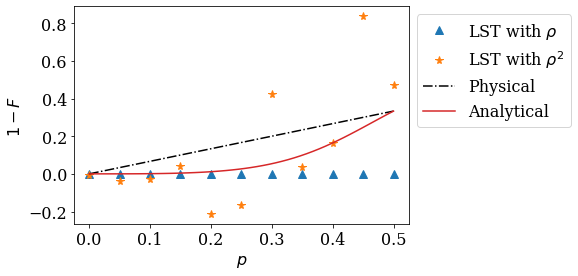

In [19]:
plt.plot(pvalues, 1 - fid_list, "^", markersize=8, label=r"LST with $\rho$")
plt.plot(pvalues, 1 - lst_vd_fids.real, "*", markersize=8, label=r"LST with $\rho^2$")
plt.plot(pvalues, 2 * pvalues / 3, "-.", c="k", label="Physical")
plt.plot(
    np.linspace(0, 0.5, 50), 1 - FL(np.linspace(0, 0.5, 50)), c="C3", label="Analytical"
)

plt.xlabel("$p$")
plt.ylabel("$1 - F$")
plt.legend(bbox_to_anchor=(1,1));